# KL Divergence Test

## General

### Imports

In [1]:
import pyvdirs.dirs as dirs
import sys
import os
sys.path.insert(0, dirs.SYSTEM_HOME)
sys.path.insert(0, os.path.join(dirs.SYSTEM_HOME, "ToyExample"))

import copy
import pickle
import builtins
import numpy as np
import torch
import matplotlib.pyplot as plt
import pyvtools.text as vtext

import ToyExample.dnnlib.util as dnnlib
from ToyExample.torch_utils import persistence
import ToyExample.training.phema as phema

import ToyExample.toy_example as toy

%load_ext autoreload
%autoreload 2

### Parameters

In [2]:
# Network parameters
classes='A'
num_layers=4
hidden_dim=64
batch_size=4<<10
total_iter=4<<10

# Distribution parameters
P_mean=-2.3
P_std=1.5
sigma_data=0.5
sigma_max=5
lr_ref=1e-2
lr_iter=512
ema_std=0.010

# Guidance parameters
guidance=False
guidance_weight=3
guide_path=os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", "Ref", "iter0512.pkl")
guide_interpolation=False

# ACID parameters
acid=False
acid_n=16
acid_f=0.8
acid_diff=True
acid_inverted=False

# Training parameters
val_batch_size=4<<7
test_batch_size=4<<8

# Other parameters
device=torch.device('cuda')
fig1_kwargs = dict(view_x=0.30, view_y=0.30, view_size=1.2, device=device)
fig2_kwargs = dict(view_x=0.45, view_y=1.22, view_size=0.3, device=device)#, sample_distance=0.045, sigma_max=0.03)
seed=0

### Initialization

In [3]:
# Set random seed, if specified
if seed is not None:
    print("Seed = ", seed)
    torch.manual_seed(seed)
    generator = torch.Generator(device).manual_seed(seed)
    np.random.seed(seed)

Seed =  0


In [4]:
# Initialize models
net = toy.ToyModel(num_layers=num_layers, hidden_dim=hidden_dim, sigma_data=sigma_data).to(device).train().requires_grad_(True)
ema = copy.deepcopy(net).eval().requires_grad_(False)
opt = torch.optim.Adam(net.parameters(), betas=(0.9, 0.99))
if guide_path is not None:
    with builtins.open(guide_path, "rb") as f:
        guide = pickle.load(f).to(device)
    print("Guide model loaded from", guide_path)
else:
    guide = None
if guidance and acid:
    ref = guide
    print("Guide model assigned as ACID reference")
elif acid: 
    ref = ema
    print("EMA assigned as ACID reference")
else: ref = None

/home/vale/anaconda3/envs/SCID/lib/python3.13/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Guide model loaded from /media/vale/QuickData/Vale/Training/models/SCID/ToyExample/10_EarlyStopACID/Ref/iter0512.pkl


## Discrete KL divergence

### General

In [5]:
def estimate_KL_divergence(model, n_samples, logging=False):
    sigma = (torch.randn(n_samples, device=device) * P_std + P_mean).exp()
    samples = toy.gt(classes, device).sample(n_samples, sigma) #Q: Why do they redefine the Gaussian mixture distribution twice on each iteration?
    gt_logp = toy.gt(classes, device).logp(samples, sigma)
    net_logp = model.logp(samples, sigma)
    if logging:
        print("Samples", samples[:10])
        print("Ground Truth Logp", gt_logp[:10])
        print("Model's Logp", net_logp[:10])
        print("Model's Max Logp", max(net_logp[:10]))
        print("Model's Min Logp", min(net_logp[:10]))
        print("Model's p", torch.exp( net_logp )[:10])
    return float(torch.sum( torch.exp( net_logp - max(net_logp) ) * (net_logp - gt_logp) ) / n_samples)

In [30]:
batch_size = 1<<18 # 1<<18 takes a full second
estimate_KL_divergence(guide, batch_size)

Samples tensor([[ 0.3750,  1.2422],
        [-0.0401,  0.0893],
        [ 2.1985,  1.0319],
        [ 0.1186,  0.0788],
        [ 0.4186,  0.4665],
        [ 0.1633,  0.5172],
        [ 0.1835,  0.2117],
        [ 0.5415,  0.6946],
        [ 0.0161,  0.5386],
        [ 0.8778, -0.0187]], device='cuda:0')
Ground Truth Logp tensor([-1.9154, -0.5419, -3.9375, -1.9402, -0.2401,  0.5995,  1.3995, -0.9313,
        -0.3543, -0.6567], device='cuda:0')
Model's Logp tensor([ 3.6239,  7.9367,  0.4473,  2.0451, 14.0206, 35.8806, 31.6398,  8.9845,
        19.9973, 31.2320], device='cuda:0')
Model's Max Logp tensor(35.8806, device='cuda:0')
Model's Min Logp tensor(0.4473, device='cuda:0')
Model's p tensor([3.7485e+01, 2.7982e+03, 1.5640e+00, 7.7302e+00, 1.2276e+06, 3.8260e+15,
        5.5081e+13, 7.9788e+03, 4.8386e+08, 3.6635e+13], device='cuda:0')


0.02727900817990303

### Check for guide and for untrained model

In [33]:
n_samples = [1<<i for i in range(13,19)]

net_mean_results, net_std_results = [], []
guide_mean_results, guide_std_results = [], []
for n in n_samples:
    net_results, guide_results = [], []
    for k in range(10): 
        net_results.append( estimate_KL_divergence(net, n) )
        guide_results.append( estimate_KL_divergence(guide, n) )
    net_mean_results.append( float(np.mean( net_results )) )
    net_std_results.append( float(np.std( net_results )) )
    guide_mean_results.append( float(np.mean( guide_results )) )
    guide_std_results.append( float(np.std( guide_results )) )


In [34]:
net_mean_results

[-0.15338555425405503,
 -0.15949326604604722,
 -0.15788108110427856,
 -0.15793289244174957,
 -0.15666548907756805,
 -0.15716473758220673]

In [35]:
net_std_results

[0.006897717240097406,
 0.006643645146808534,
 0.006324348566740532,
 0.001403445788673892,
 0.0017624047203736685,
 0.0020937785389164294]

In [36]:
guide_mean_results

[0.41950732171535493,
 0.2291453957557678,
 0.1409598931670189,
 0.10249877572059632,
 0.05564229823648929,
 0.03509714342653751]

In [37]:
guide_std_results

[0.1693544528145813,
 0.07284975098757966,
 0.053083673239432735,
 0.055096763107228844,
 0.015086107040142663,
 0.00745716254367764]

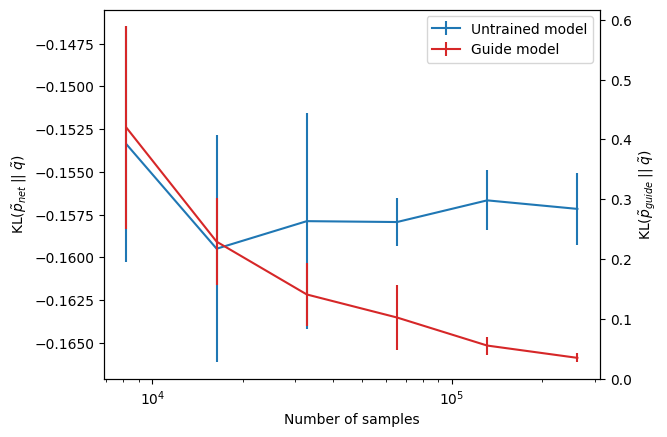

In [53]:
fig, axes = plt.subplots()
axes = [axes, axes.twinx()]
l0 = axes[0].errorbar(n_samples, net_mean_results, net_std_results, 
                      color="C0", label="Untrained model")
l1 = axes[1].errorbar(n_samples, guide_mean_results, guide_std_results, 
                      color="C3", label="Guide")
for ax in axes: ax.set_xscale("log")
axes[0].set_ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
axes[1].set_ylabel(r"KL$(\tilde{p}_{guide}\;||\;\tilde{q})$");
axes[0].set_xlabel("Number of samples");
plt.legend([l0, l1], ["Untrained model", "Guide model"])

### Check for all different checkpoints in a training run

In [9]:
n_samples = 1<<17
checkpoints_path = os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", 
                                "InvertedGuideACID")

checkpoints = os.listdir(checkpoints_path)
checkpoints = vtext.filter_by_string_must(checkpoints, ".pkl")
checkpoints = vtext.filter_by_string_must(checkpoints, "learner", must=False)
checkpoints_filepaths = [os.path.join(checkpoints_path, filename) for filename in checkpoints]
n_iterations = [vtext.find_numbers(filename)[0] for filename in checkpoints]

In [ ]:
mean_results, std_results = [], []
for filepath in checkpoints_filepaths:
    
    # Load checkpoint
    with builtins.open(filepath, "rb") as f:
        model = pickle.load(f).to(device)
    results = []
    
    # Estimate 10 times
    for k in range(10): 
        results.append( estimate_KL_divergence(model, n_samples) )
    
    # Get mean and standard deviation
    mean_results.append( float(np.mean( results )) )
    std_results.append( float(np.std( results )) )

# 16 checkpoints took 7 min ==> 27 sec per checkpoint, quite expensive

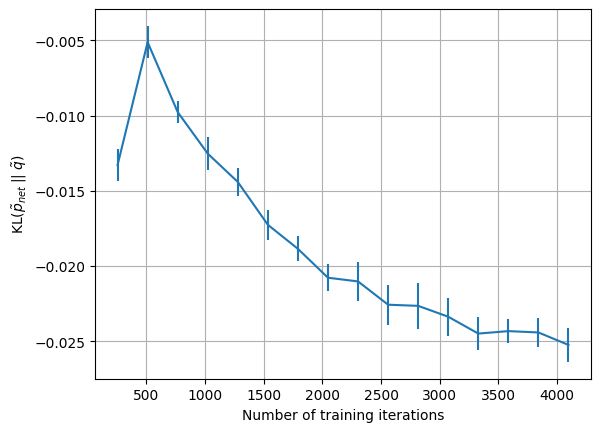

In [14]:
plt.figure()
plt.errorbar(n_iterations, mean_results, std_results, color="C0")
plt.ylabel(r"KL$(\tilde{p}_{net}\;||\;\tilde{q})$");
plt.xlabel("Number of training iterations");
plt.grid()

## Continuous KL divergence

In [18]:
grid_resolution=400

# grid_x = np.linspace(fig1_kwargs["view_x"] - fig1_kwargs["view_size"],
#                      fig1_kwargs["view_x"] + fig1_kwargs["view_size"],
#                      grid_resolution)
# grid_y = np.linspace(fig1_kwargs["view_y"] - fig1_kwargs["view_size"],
#                      fig1_kwargs["view_y"] + fig1_kwargs["view_size"],
#                      grid_resolution)
# samples_x, samples_y = np.meshgrid(grid_x, grid_y, indexing='xy')
# samples = np.array([samples_x, samples_y]).T # (X_Index, Y_Index, X_Y)

grid_x = torch.linspace(fig1_kwargs["view_x"] - fig1_kwargs["view_size"],
                        fig1_kwargs["view_x"] + fig1_kwargs["view_size"],
                        grid_resolution, device=device)
grid_y = torch.linspace(fig1_kwargs["view_y"] - fig1_kwargs["view_size"],
                        fig1_kwargs["view_y"] + fig1_kwargs["view_size"],
                        grid_resolution, device=device)
samples_x, samples_y = torch.meshgrid(grid_x, grid_y, indexing='xy')
samples = torch.stack([samples_x, samples_y]).swapaxes(0,2) # (X_Index, Y_Index, X_Y)

In [59]:
def f(model, samples, 
    #   guidance=1, guide=None, num_steps=32, sigma_min=0.002, sigma_max=5, rho=7,
      logging=False): # Samples are (x, y) points in the 2D plane

    gt_logp = toy.gt(classes, device).logp(samples, sigma=0)
    net_logp = model.logp(samples, sigma=0)    
    # Sigma = 0 for ground truth
    # Sigma = Sigma_Max for Gaussian noise
    
    # trajectories = toy.do_sample(model, samples, guidance=guidance, gnet=guide, 
    #     num_steps=num_steps, sigma_min=sigma_min, sigma_max=sigma_max, rho=rho)
    # net_logp = model.logp(trajectories[-1], sigma=0)

    if logging:
        print("Samples", samples[200:210,205])
        print("Ground Truth Logp", gt_logp[200:210,205])
        print("Model's Logp", net_logp[200:210,205])
        print("> Any not NaN values inside Model's Logp?", not(torch.all(torch.isnan(net_logp))))
        print("Model's Max Logp", max(net_logp[200:210,205]))
        print("Model's Min Logp", min(net_logp[200:210,205]))
        print("Model's p", torch.exp( net_logp )[200:210,205])
    return float(torch.sum( torch.exp( net_logp - max(net_logp) ) * (net_logp - gt_logp) ) / n_samples)

In [60]:
f_samples = f(model, samples, logging=True)

Samples tensor([[0.3030, 0.3331],
        [0.3090, 0.3331],
        [0.3150, 0.3331],
        [0.3211, 0.3331],
        [0.3271, 0.3331],
        [0.3331, 0.3331],
        [0.3391, 0.3331],
        [0.3451, 0.3331],
        [0.3511, 0.3331],
        [0.3571, 0.3331]], device='cuda:0')
Ground Truth Logp tensor([-2.7573, -3.3821, -4.0284, -4.7026, -5.3856, -6.0678, -6.7694, -7.5172,
        -8.3129, -9.1329], device='cuda:0')
Model's Logp tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
> Any not NaN values inside Model's Logp? False
Model's Max Logp tensor(nan, device='cuda:0')
Model's Min Logp tensor(nan, device='cuda:0')
Model's p tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
f_samples = f(guide, samples, logging=True)

Samples tensor([[0.3030, 0.3331],
        [0.3090, 0.3331],
        [0.3150, 0.3331],
        [0.3211, 0.3331],
        [0.3271, 0.3331],
        [0.3331, 0.3331],
        [0.3391, 0.3331],
        [0.3451, 0.3331],
        [0.3511, 0.3331],
        [0.3571, 0.3331]], device='cuda:0')
Ground Truth Logp tensor([-2.7573, -3.3821, -4.0284, -4.7026, -5.3856, -6.0678, -6.7694, -7.5172,
        -8.3129, -9.1329], device='cuda:0')
Model's Logp tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
> Any not NaN values inside Model's Logp? False
Model's Max Logp tensor(nan, device='cuda:0')
Model's Min Logp tensor(nan, device='cuda:0')
Model's p tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
# def estimate_KL_divergence(model, n_samples, logging=False):
#     sigma = (torch.randn(n_samples, device=device) * P_std + P_mean).exp()
#     samples = toy.gt(classes, device).sample(n_samples, sigma)
#     gt_logp = toy.gt(classes, device).logp(samples, sigma)
#     net_logp = model.logp(samples, sigma)
#     if logging:
#         print("Samples", samples[:10])
#         print("Ground Truth Logp", gt_logp[:10])
#         print("Model's Logp", net_logp[:10])
#         print("Model's Max Logp", max(net_logp[:10]))
#         print("Model's Min Logp", min(net_logp[:10]))
#         print("Model's p", torch.exp( net_logp )[:10])
#     return float(torch.sum( torch.exp( net_logp - max(net_logp) ) * (net_logp - gt_logp) ) / n_samples)